# Homework 1 (Total Points: 175)



Learning Goals:
- Learn how to load a dataset and process it.
- Learn how to implement several IR methods (TFIDF, BM25, QL) and understand their weaknesses & strengths.
- Learn how to evaluate IR methods


**NOTE 1**: Only the code (`TODO: Implement this!` denotes these sections) is graded. The 'theory' questions in this assignment serve as a preparation for the exam and to facilitate a deeper understanding of the course content. These questions (denoted by `TODO: Answer this!`) have no points assigned to them, but **need** to be filled out before submission.  

**NOTE 2**: You can use the `nltk`, `numpy` and `matplotlib` libraries here. Other libraries, e.g., `gensim` or `scikit-learn`, may not be used. 

**NOTE 3**: The notebook you submit has to have the student ids, seperated by underscores (E.g., `12341234_12341234_12341234.ipynb`). 

**NOTE 4**: Make sure to check that your notebook runs before submission. A quick way to do this is to restart the kernel and run all the cells.  

---
Additional Resources: 
-  Sections 2.3, 4.1, 4.2, 4.3, 5.3, 5.6, 5.7, 6.2, 7, 8 of [Search Engines: Information Retrieval in Practice](https://ciir.cs.umass.edu/downloads/SEIRiP.pdf)


In [1]:
# imports 
# TODO: Ensure that no additional library is imported in the notebook. 
# TODO: Only the standard library and the following libraries are allowed:

import os
import zipfile
from functools import partial

import nltk
import requests
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.html import widgets
from collections import namedtuple

%matplotlib inline

/home/choenes/miniconda3/envs/ml1labs/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Section 1: Text Processing (20 points)

In this section, we will load the dataset and learn how to clean up the data to make it usable for an IR system. 

We are using the [CACM dataset](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/), which is a small, classic IR dataset, composed of a collection of titles and abstracts from the journal CACM. It comes with relevance judgements for queries, so we can evaluate our IR system. 

The following cell downloads the dataset and unzips it to a local directory

In [2]:
def download_dataset(folder_path = "./datasets/"):
    
    os.makedirs(folder_path, exist_ok=True)
    
    file_location = os.path.join(folder_path, "cacm.zip")
    
    # download file if it doesn't exist
    if not os.path.exists(file_location):
        
        url = "https://surfdrive.surf.nl/files/index.php/s/M0FGJpX2p8wDwxR/download"

        with open(file_location, "wb") as handle:
            print(f"Downloading file from {url} to {file_location}")
            response = requests.get(url, stream=True)
            for data in tqdm(response.iter_content()):
                handle.write(data)
            print("Finished downloading file")
    
    if not os.path.exists(os.path.join(folder_path, "train.txt")):
        
        # unzip file
        with zipfile.ZipFile(file_location, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
download_dataset()

You can see a brief description of each file in the dataset by looking at the README file

In [3]:
##### Read the README file 
!cat ./datasets/README
#####

Files in this directory with sizes:
          0 Jun 19 21:01 README

    2187734 Jun 19 20:55 cacm.all              text of documents
        626 Jun 19 20:58 cite.info             key to citation info
                                                (the X sections in cacm.all)
       2668 Jun 19 20:55 common_words           stop words used by smart
       2194 Jun 19 20:55 make_coll*             shell script to make collection
       1557 Jun 19 20:55 make_coll_term*        ditto (both useless without
                                                smart system)
       9948 Jun 19 20:55 qrels.text             relation giving
                                                    qid did 0 0
                                                to indicate dument did is
                                                relevant to query qid
      13689 Jun 19 20:55 query.text             Original text of the query


----
We are interested in 4 files:
- `cacm.all` : Contains the text for all documents. Note that some documents do not have abstracts available. 
- `query.text` : The text of all queries
- `qrels.text` : The relevance judgements
- `common_words` : A list of common words. This may be used as a collection of stopwords

In [4]:
##### The first 45 lines of the CACM dataset forms the first record
# We are interested only in 3 fields. 
# 1. the '.I' field, which is the document id
# 2. the '.T' field (the title) and
# 3. the '.W' field (the abstract, which may be absent)
!head -45 ./datasets/cacm.all
#####

.I 1
.T
Preliminary Report-International Algebraic Language
.B
CACM December, 1958
.A
Perlis, A. J.
Samelson,K.
.N
CA581203 JB March 22, 1978  8:28 PM
.X
100	5	1
123	5	1
164	5	1
1	5	1
1	5	1
1	5	1
205	5	1
210	5	1
214	5	1
1982	5	1
398	5	1
642	5	1
669	5	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
165	6	1
196	6	1
196	6	1
1273	6	1
1883	6	1
324	6	1
43	6	1
53	6	1
91	6	1
410	6	1
3184	6	1


---

Now, write a function to read in the `cacm.all` file. Note that each document has a variable number of lines. The `.I` field denotes a new document

In [5]:
# TODO: Implement this! (4 points)
def read_cacm_docs(root_folder = "./datasets/"):
    """
        Reads in the CACM documents. The dataset is assumed to be in the folder "./datasets/cacm" be default
        Returns: A list of 2-tuples: (doc_id, document), where 'document' is a single string created by 
            appending the title and abstract (seperated by a "\n"). 
            In case the record doesn't have an abstract, the document is composed only by the title
    """
    
    file_path = os.path.join(root_folder, 'cacm.all')
    with open(file_path, 'r') as f:
        docs = []
        title = ''
        abstract = ''
        in_title = False
        in_abstract = False
        for line in f:
            if line.startswith('.I '):
                doc_id = line.strip('\n').split('.I ')[1]
            if line.startswith('.B'):
                in_title = False
                in_abstract = False
                docs.append((int(doc_id),title+abstract))
                title = ''
                abstract = ''
            if in_abstract:
                abstract = abstract + line
            if line.startswith('.W'):
                in_title = False
                in_abstract = True
            if in_title:
                title = title + line
            if line.startswith('.T'):
                in_title = True
    return docs

                
docs = read_cacm_docs()

In [6]:
print(docs[99])

(100, 'Recursive Subscripting Compilers and List-Types Memories\n')


In [7]:
##### 
assert len(docs) == 3204, "There should be exactly 3024 documents"
##### 

---

Next, let us read the queries. They are formatted similarly: 

In [8]:
##### The first 15 lines of 'query.text' has 2 queries
# We are interested only in 2 fields. 
# 1. the '.I' - the query id
# 2. the '.W' - the query
# 3. the '.W' field (the abstract, which may be absent)
!head -15 ./datasets/query.text
#####

.I 1
.W
 What articles exist which deal with TSS (Time Sharing System), an
operating system for IBM computers?
.N
 1. Richard Alexander, Comp Serv, Langmuir Lab (TSS)
 
.I 2
.W
 I am interested in articles written either by Prieve or Udo Pooch
.A
Prieve, B.
Pooch, U.
.N
 2. Richard Alexander, Comp Serv, Langmuir Lab (author = Pooch or Prieve)


---

Now, write a function to read in this file:

In [9]:
# TODO: Implement this! (3 points)
def read_queries(root_folder = "./datasets/"):
    """
        Reads in the CACM queries. The dataset is assumed to be in the folder "./datasets/" be default
        Returns: A list of 2-tuples: (query_id, query)
    """
    file_path = os.path.join(root_folder, 'query.text')
    with open(file_path, 'r') as f:
        queries = []
        query = ''
        in_query = False
        for line in f:
            if line.startswith('.I '):
                query_id = line.strip('\n').split('.I ')[1]
            if line.startswith('.A'):
                in_query = False
            if line.startswith('.N'):
                in_query = False
                queries.append((int(query_id),query))
                query = ''
            if in_query:
                query = query + line
            if line.startswith('.W'):
                in_query = True
    return queries
    
queries = read_queries()

In [10]:
print(queries[5])

(6, ' Interested in articles on robotics, motion planning particularly the\ngeometric and combinatorial aspects.  We are not interested in the\ndynamics of arm motion.\n')


In [11]:
##### 
assert len(queries) == 64 and all([q[1] is not None for q in queries]), "There should be exactly 64 queries"
##### 

---

Read in the stop words:

In [12]:
!head ./datasets/common_words

a
about
above
accordingly
across
after
afterwards
again
against
all


In [13]:
# TODO: Implement this! (3 points)
def load_stopwords(root_folder = "./datasets"):
    """
    Load the stopwords
    Output: A set of stopwords
    """
    stopwords = set()
    file_path = os.path.join(root_folder, 'common_words')
    with open(file_path, 'r') as f:
        for line in f:
            stopwords.add(line.strip('\n'))
    return stopwords   

stopwords = load_stopwords()
assert len(stopwords) == 428

--- 

We can now write some basic text processing functions. A first step is to tokenize the text. You may use any tokenizer available in the `nltk` library:

In [14]:
# TODO: Implement this! (5 points)
def tokenize(text):
    """
        Tokenize the text. 
        Input: text - a string
        Output: a list of tokens
    """
    return nltk.tokenize.word_tokenize(text)

In [15]:
#####
text = "the quick brown fox jumps over the lazy dog"
tokens = tokenize(text)
print(tokens)
#####

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


---

*Answer the following questions*: 
- Why is stemming necessary, in particular for IR?
    - Depending on the language words can come in various forms (pre- and suffixes). To make sure not to miss relevant documents that only contain a different form of the word stemming can be applied. Stemming is important for recall.
- Is there any setting (domain, scenario, etc) in which stemming can hurt performance? Illustrate with an example
    - Sometimes stemming can lead to ambiguity e.g organisation -> organ and therefore irelevant documents could be mistakenly selected. Stemming can hurt precision in some cases.

Write a function to stem tokens. Again, you can use the `nltk` library for this

In [16]:
# TODO: Implement this! (5 points)
def stem_token(token):
    """
        Stem the given token, using any stemmer available from the nltk library
        Input: a single token
        Output: the stem of the token
    """
    stemmer = nltk.stem.porter.PorterStemmer()
    return stemmer.stem(token)

In [17]:
####
print([stem_token(t) for t in tokens])
tokens_ = [
    'caresses', 'flies', 'dies', 'mules', 'denied',
    'died', 'agreed', 'owned', 'humbled', 'sized',
    'meeting', 'stating', 'siezing', 'itemization',
    'sensational', 'traditional', 'reference', 'colonizer',
    'plotted']
print([stem_token(t) for t in tokens_])
####

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog']
['caress', 'fli', 'die', 'mule', 'deni', 'die', 'agre', 'own', 'humbl', 'size', 'meet', 'state', 'siez', 'item', 'sensat', 'tradit', 'refer', 'colon', 'plot']


---

*Answer the following questions*: 
- Another processing step (not done here) is to use n-grams. Illustrate why you would want to use n-grams in IR with an example.  
    - n-grams can capture context information. For example if you are only interested in a specific kind of housing e.g. stdent housing a bigram can better capture what documents might be relevant for you by not returning documents that only contain the word housing in a different context.
- Usage of n-grams exacerbates some problems ex. in bi-gram language models. What is this problem? Suggest one solution 
    - n-gram models increase the vocabulary size a lot but also decrease the occurances of each n-gram. smoothing?

--- 

The following function puts it all together. Given a string, it tokenizes it, and processes it according to the flags that you set.

In [18]:
#### Putting it all together
def process_text(text, stem=False, remove_stopwords=False, lowercase_text=False):
    
    tokens = []
    for token in tokenize(text):
        if remove_stopwords and token.lower() in stopwords:
            continue
        if stem:
            token = stem_token(token)
        if lowercase_text:
            token = token.lower()
        tokens.append(token)

    return tokens
#### 

Let's create two sets of pre-processed documents

In [19]:
# In this configuration:
# Don't preprocess the text, except to tokenize 
config_1 = {
  "stem": False,
  "remove_stopwords" : False,
  "lowercase_text": True
} 


# In this configuration:
# Preprocess the text: stem and remove stopwords
config_2 = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True, 
} 


We can now process the documents and queries according to the configuration specified above

In [20]:
####
doc_repr_1 = []
doc_repr_2 = []
for (doc_id, document) in docs:
    doc_repr_1.append((doc_id, process_text(document, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, **config_2)))
####


--- 

## Section 2: Indexing (10 points)


A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


### Building an index

A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


---

In this assignment we will be using an index created in memory, since our dataset is tiny. To get started, build a simple index that maps simply counts the number of tokens present in a document. This index  is built using a python dictionary.

*Answer the following questions*:
- What is the time complexity of retrieving a list of documents from a python `dict` object? 
    - retrieving a single element from a python dict is in average O(1) and worst case O($n$), where n is the size of the dictionary. So for a list of M documents the average time complexity is O($M$) and the worst case time complexity is O($n*M$)
- Consider the case with a 10 million documents. What is the time complexity of retrieval with an inverted index (assuming you can fit the entire index in memory)? (Hint: Consider length of a query $|q|$) 
    - Analogously, to above in average the time complexity is O($|q|$) and in the worst case O(n*$|q|$), where n is the size of the dictionary (number of words)
- For a large enough collection, we cannot store an index in memory. How is this tackled in practice (briefly explain)? Comment on the time complexity. 
    - You can have multiple indicies and search them separately. two-pass, one-pass?
- Mention a use-case in which a simple index (from word -> doc_id) might not suffice anymore. How would you modify the index to suit this use-case (if you can!)  
    - you might want to store word order or word count in your index as well to be able to tell which documents are most relevant (e.g. multiple occurances more important than few)
    
    
Now, implement a function to build an index:

In [21]:
# TODO: Implement this! 10 points
from collections import defaultdict, Counter
def build_tf_index(documents):
    """
    Build an inverted index (with counts). The output is a dictionary which takes in a token
    and returns a list of (doc_id, count) where 'count' is the count of the 'token' in 'doc_id'
    Input: a list of documents - (doc_id, tokens) 
    Output: An inverted index. [token] -> [(doc_id, token_count)]
    """
    index = defaultdict(set)
    for doc_id, text in documents:
        word_counter = Counter(text)
        for word, token_count in word_counter.items():
            index[word].add((doc_id, token_count))
    return index
        
 
# Create the 2 indices
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)

# This function returns the correct index 
def get_index(index_set):
    assert index_set in {1, 2}
    return {
        1: tf_index_1,
        2: tf_index_2
    }[index_set]

# This function correctly pre-processes the text given the index set
def preprocess_query(text, index_set):
    assert index_set in {1, 2}
    if index_set == 1:
        return process_text(text, **config_1)
    elif index_set == 2:
        return process_text(text, **config_2)
    

--- 

## Section 3: Retrieval  (80 points)

Now that we have cleaned and processed our dataset, we can start building simple IR systems. 

For now, we consider *simple* IR systems, which involve computing scores from the tokens present in the document/query. More advanced methods are covered in later assignments.

We will implement the following methods in this section:
- TF-IDF
- BM25
- Query Likelihood Models

--- 

### Ranking functions


Probably the simplest IR model is the Bag of Words (BOW) model. Implement a function that scores a query against a document using this model.   

Note that you can use either the count of the token or 'binarize' it i.e set the value equal to 1 if the token appears.   


**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

In [22]:
# TODO: Implement this! 10 points
def bow_search(query, index_set):
    """
        Perform a search over all documents with the given query. 
        Note #1: You have to use the `get_index` function created in the previous cells
        Note #2: You can binarize the counts if you wish to
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    binarize = False
    query = preprocess_query(query, index_set)
    index = get_index(index_set)
    ranking = []
    
    scores = defaultdict(lambda: 0)
    for token in query:
        search_results = index[token]
        for document_id, score in search_results:
            scores[document_id] += 1.0 if binarize else float(score)
    ranking = list(scores.items())
    ranking.sort(key= lambda tup: tup[1], reverse=True)
    return ranking
    
        

*Answer the following questions*: 
- The BOW model is might not be a good choice for use in IR. Why? 
    - Word order is not taken into account therefore it is not possible to search for n-grams. Sometimes the word order is important e.g. in negation and can completely change (invert) the semantic meaning.

In [23]:
####
docs_by_id = dict(docs)
def print_results(docs, len_limit=50):    
    for i, (doc_id, score) in enumerate(docs):
        doc_content = docs_by_id[doc_id].strip().replace("\n", "\\n")[:len_limit] + "..."
        print(f"Rank {i}({score:.2}): {doc_content}")

test_bow = bow_search("report", index_set=1)[:5]
print(f"BOW Results:")
print_results(test_bow)
#### 

BOW Results:
Rank 0(6.0): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(5.0): An Information Algebra - Phase I Report-Language\n...
Rank 2(3.0): ALGOL 60 Confidential\nThe ALGOL 60 Report,* when ...
Rank 3(2.0): Curriculum Recommendations for Graduate Profession...
Rank 4(2.0): Control Procedures for Data Communication-An ASA P...


Before we implement the tf-idf scoring functions, let's first write a function to compute the document frequencies of all words.  

In [24]:
# TODO: Implement this! (5 points)
def compute_df(documents):
    """
        Compute the document frequency of all terms in the vocabulary
        Input: A list of documents
        Output: A dictionary with {token: document frequency)
    """
    doc_freqs = defaultdict(lambda:1e-8)
    for doc in documents:
        unique_tokens = set(doc)
        for token in unique_tokens:
            doc_freqs[token] += 1
    return doc_freqs


# get the document frequencies of each document
df_1 = compute_df([d[1] for d in doc_repr_1])
df_2 = compute_df([d[1] for d in doc_repr_2])

def get_df(index_set):
    assert index_set in {1, 2}
    return {
        1: df_1,
        2: df_2
    }[index_set]

Next, implement a function that computes a tf-idf score given a query.      

In [25]:
# TODO: Implement this! 10 points
import math # only for log

# This function returns the correct document representation
# used to get document length
def get_docs(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_repr_1,
        2: doc_repr_2
    }[index_set]

def tfidf_search(query, index_set):
    """
        Perform a search over all documents with the given query using tf-idf. 
        Note #1: You have to use the `get_index` (and the `get_df`) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    query = preprocess_query(query, index_set)
    index = get_index(index_set)
    df = get_df(index_set)
    ranking = []
    
    scores = defaultdict(lambda: 0.0)
    for token in query:
        search_results = index[token]
        docs = get_docs(index_set)
        idf = math.log(len(docs)/df[token])
        for document_id, tf in search_results:
            scores[document_id] += tf * idf
    ranking = list(scores.items())
    ranking.sort(key= lambda tup: tup[1], reverse=True)
    return ranking
    

In [26]:
####
test_tfidf = tfidf_search("report", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_tfidf)
####

TFIDF Results:
Rank 0(2.4e+01): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(2e+01): An Information Algebra - Phase I Report-Language\n...
Rank 2(1.2e+01): ALGOL 60 Confidential\nThe ALGOL 60 Report,* when ...
Rank 3(7.9): Curriculum Recommendations for Graduate Profession...
Rank 4(7.9): Control Procedures for Data Communication-An ASA P...


*Answer the following questions*: 
- It is generally not advisable to use the naive version of tf-idf. Why?
    - TF should be normalized to ...get more stable results??? 
- Illustrate with an example why using a sublinear scaling for TF is preferable in some cases.  
    - Spamming a certain word in unserious websites like ... should not affect ranking ???

--- 

*Answer the following questions*: 
- An alternative way to compute a query<>document score is to vectorize both the query and document (where each dimension corresponds to a token), and compute a score. The score can be computed using a dot product between the query and the document vectors. Why is the cosine similary function a better choice, particularly in IR? 
    - Cosine similarity measures angle between the vectors regardless the magnitude. The value is normalized? (only values between -1 and 1) and is hence better interpretable as a similarity measure.
- What is the time complexity of a search if we are using the vector space method mentioned in the previous question? What is the time complexity if we're using an index (assume that it fits in memory)? Assume $N$ is the number of documents and $|q|$ is the length of a query. 
    - Vector O($N*|q|$) vs. index O($|q|$)

--- 

#### Query Likelihood Models

In this section you will implement a simple query likelihood model. 

First, let use implement a naive version of a QL model, assuming a multinomial unigram language model (with a uniform prior over the documents). 

**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

--- 

*Answer the following questions*: 
- Write down the formula for computing the query likelihood, assuming a multinomial unigram language model. 
    - $K\Pi_{i=1}{N}P(t_{i|D)$, where K is the multinomial coefficient (constant for a corpus)
- What problem does this naive method have? Suggest a simple way to fix it.
    - If only one queryword is not in the document then the whole likelihood becomes 0. A simple way to fix this is smoothing. E. g. Laplace (also called add-one) smoothing avoids 0 likelihoods by adding one to each word in the vocabulary.

In [27]:
####
def doc_lengths(documents):
    doc_lengths = {doc_id:len(doc) for (doc_id, doc) in documents}
    return doc_lengths

doc_lengths_1 = doc_lengths(doc_repr_1)
doc_lengths_2 = doc_lengths(doc_repr_2)

def get_doc_lengths(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_lengths_1,
        2: doc_lengths_2
    }[index_set]
####

In [28]:

# TODO: Implement this! 15 points
def naive_ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a naive QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    query = preprocess_query(query, index_set)
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    ranking = []
    
    scores = defaultdict(lambda: 1.0)
    for token in query:
        all_doc_ids = list(doc_lengths.keys())
        search_results = index[token]
        for document_id, tf in search_results:
            scores[document_id] *= tf/doc_lengths[document_id]
            all_doc_ids.remove(document_id)
        for document_id in all_doc_ids:
            scores[document_id] *= 0.0
    ranking = list(scores.items())
    ranking.sort(key= lambda tup: tup[1], reverse=True)
    return ranking

In [29]:
####
test_naiveql = naive_ql_search("report", index_set=1)[:5]
print(f"Naive QL Results:")
print_results(test_naiveql)
####

Naive QL Results:
Rank 0(0.2): A Report Writer For COBOL...
Rank 1(0.2): A CRT Report Generating System...
Rank 2(0.2): ALGOL Sub-Committee Report - Extensions...
Rank 3(0.17): Supplement to the ALGOL 60 Report...
Rank 4(0.14): Report on the Algorithmic Language FORTRAN II...


Now, let's implement a (slightly more) complex QL model. This model should 'fix' the issue with the previous method. If your model requires hyperparameters, set a reasonable value. 

In [30]:
# TODO: Implement this! 20 points
smoothing = 0.1
def ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a appropriate QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    query = preprocess_query(query, index_set)
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    total_corpus_length = sum(doc_lengths.values())
    ranking = []
    
    #scores = defaultdict(lambda: 0.0)
    scores = defaultdict(lambda: 1.0)
    for token in query:
        all_doc_ids = list(doc_lengths.keys())
        search_results = index[token]
        collection_probability = sum([tf for _, tf in search_results])/total_corpus_length
        for document_id, tf in search_results:
            #scores[document_id] += math.log((1-smoothing)*tf/doc_lengths[document_id]+smoothing*collection_probability)
            scores[document_id] *= (1-smoothing)*tf/doc_lengths[document_id]+smoothing*collection_probability
            all_doc_ids.remove(document_id)
        for document_id in all_doc_ids:
            #scores[document_id] += math.log(smoothing*collection_probability)
            scores[document_id] *= smoothing*collection_probability
    ranking = list(scores.items())
    ranking.sort(key= lambda tup: tup[1], reverse=True)
    return ranking

In [31]:
#### Test the QL model
test_ql_results = ql_search("report", index_set=1)[:5]
print_results(test_ql_results)
print()
test_ql_results_long = ql_search("report " * 10, index_set=1)[:5]
print_results(test_ql_results_long)
####

Rank 0(0.18): A Report Writer For COBOL...
Rank 1(0.18): A CRT Report Generating System...
Rank 2(0.18): ALGOL Sub-Committee Report - Extensions...
Rank 3(0.15): Supplement to the ALGOL 60 Report...
Rank 4(0.13): Report on the Algorithmic Language FORTRAN II...

Rank 0(3.6e-08): A Report Writer For COBOL...
Rank 1(3.6e-08): A CRT Report Generating System...
Rank 2(3.6e-08): ALGOL Sub-Committee Report - Extensions...
Rank 3(5.8e-09): Supplement to the ALGOL 60 Report...
Rank 4(1.2e-09): Report on the Algorithmic Language FORTRAN II...


*Answer the following questions*: 
- What happens to the query likelihood for long queries? What is a simple fix for this issue?
    - The likelihoods become very small which can cause numerical instabilities for large queries due to the product over all query word probabilities. A simple fix would be to use the log likelihood instead. Then the product would be replaced by a sum which is more stable.


--- 

#### BM25

In this section, we will implement the widely used and hard to beat BM25 scoring function. 


In [32]:
# TODO: Implement this! (20 points)
def bm25_search(query, index_set):
    """
        Perform a search over all documents with the given query using BM25. 
        Note #1: You have to use the `get_index` (and `get_doc_lengths`) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    query = preprocess_query(query, index_set)
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    N = len(doc_lengths)
    ranking = []
    
    k1 = 1.2
    b = 0.75
    k2 = 100
    avgdl = sum(doc_lengths.values())/N
    
    qf = defaultdict(lambda: 0.0)
    for token in query:
        qf[token] += 1.0
    scores = defaultdict(lambda: 0.0)
    for token in set(query):
        #all_doc_ids = list(doc_lengths.keys())
        search_results = index[token]
        ni = len(search_results)
        #N = sum([tf for _, tf in search_results])
        for document_id, tf in search_results:
            dl = doc_lengths[document_id]
            K = k1*((1-b)+b*(dl/avgdl))
            scores[document_id] += math.log(1/((ni+0.5)/(N-ni+0.5)))*(((k1+1)*tf)/(K+tf))*(((k2+1)*qf[token])/(k2*qf[token]))
        #    all_doc_ids.remove(document_id)
        #for document_id in all_doc_ids:
        #    scores[document_id] += math.log(smoothing*collection_probability)
    ranking = list(scores.items())
    ranking.sort(key= lambda tup: tup[1], reverse=True)
    return ranking


In [33]:
#### Test the BM25 model
test_bm25_results = bm25_search("report", index_set=1)[:5]
print_results(test_bm25_results)
####

Rank 0(6.3): A Report Writer For COBOL...
Rank 1(6.3): A CRT Report Generating System...
Rank 2(6.3): ALGOL Sub-Committee Report - Extensions...
Rank 3(6.2): Supplement to the ALGOL 60 Report...
Rank 4(6.2): Report on the Algorithmic Language FORTRAN II...




*Answer the following questions*: 
- Briefly explain how the BM25 model improves upon the tf-idf model.
    - It introduces document and query term weights that can be tuned which makes the model more flexible. Can be adjusted to the corpus
    
---

In [34]:
#### Highlighter function
# class for results
ResultRow = namedtuple("ResultRow", ["doc_id", "snippet", "score"])
# doc_id -> doc
docs_by_id = dict((d[0], d[1]) for d in docs)

def highlight_text(document, query, tol=17):
    import re
    tokens = tokenize(query)
    regex = "|".join(f"(\\b{t}\\b)" for t in tokens)
    regex = re.compile(regex, flags=re.IGNORECASE)
    output = ""
    i = 0
    for m in regex.finditer(document):
        start_idx = max(0, m.start() - tol)
        end_idx = min(len(document), m.end() + tol)
        output += "".join(["...",
                        document[start_idx:m.start()],
                        "<strong>",
                        document[m.start():m.end()],
                        "</strong>",
                        document[m.end():end_idx],
                        "..."])
    return output.replace("\n", " ")


def make_results(query, search_fn, index_set):
    results = []
    for doc_id, score in search_fn(query, index_set):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results
####

---
---

The widget below allows you to play with the search functions you've written so far. This can be used, for example, to answer some of the theory questions

In [35]:
# Set this to the function you want to test
# this function should take in a query (string)
# and return a sorted list of (doc_id, score) 
# with the most relevant document in the first position
search_fn = bm25_search
index_set = 1

text = widgets.Text(description="Search Bar", width=200)
display(text)

def handle_submit(sender):
    print(f"Searching for: '{sender.value}'")
    
    results = make_results(sender.value, search_fn, index_set)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit)

Text(value='', description='Search Bar')

## Section 4: Offline Evaluation (45 points)

Before we jump in and implement an algorithm for retrieval, we first have to learn how to evaluate such a system. In particular, we will work with offline evaluation metrics. These metrics are computed on a dataset with known relevance judgements.

Implement the following evaluation metrics. 

1. Precision
2. Recall
3. Mean Average Precision
4. Expected Reciprocal Rank

---
*Answer the following questions*: 
- What are the main limitations of an offline evaluation?
    - Offline evaluation methods are static and do not always correlate well with the performance in real-world scenarios

---

Let's take a look at the `qrels.text` file, which contains the ground truth relevance scores. The relevance labels for CACM are binary - either 0 or 1. 


In [36]:
!head ./datasets/qrels.text

01 1410  0 0
01 1572  0 0
01 1605  0 0
01 2020  0 0
01 2358  0 0
02 2434  0 0
02 2863  0 0
02 3078  0 0
03 1134  0 0
03 1613  0 0


The first column is the `query_id` and the second column is the `document_id`. You can safely ignore the 3rd and 4th columns. Write a function to read in the file: 

In [37]:
# TODO: Implement this!
def read_qrels(root_folder = "./datasets/"):
    """
        Reads the qrels.text file. 
        Output: A dictionary: query_id -> [list of relevant documents]
    """
    qrels = defaultdict(list)
    file_path = os.path.join(root_folder,'qrels.text')
    with open(file_path, 'r') as f:
        for line in f:
            row = line.split()
            qrels[int(row[0].lstrip("0"))].append(int(row[1]))
    return qrels
            
qrels = read_qrels()

In [38]:
####
assert len(qrels) == 52, "There should be 52 queries with relevance judgements"
assert sum(len(j) for j in qrels.values()) == 796, "There should be a total of 796 Relevance Judgements"
####

Now, implement the metrics below. 

**Note:** For a given query `query_id`, you can assume that documents *not* in `qrels[query_id]` are not relevant to `query_id`. 


In [39]:
# TODO: Implement this! (10 points)
#from decimal import Decimal
def recall_k(results, relevant_docs, k):
    """
        Compute Recall@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Recall@K
    """
    assert k > 0, "k must be a positive integer"
    recalled = 0.0
    k_result_ids = [result[0] for result in results[:k]]
    for doc_id in relevant_docs:
        if doc_id in k_result_ids:
            recalled += 1.0
    return recalled/min(k,len(relevant_docs))
    
# TODO: Implement this! (10 points)
def precision_k(results, relevant_docs, k):
    """
        Compute Precision@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), 
                    with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Precision@K
    """
    assert k > 0, "k must be a positive integer"
    k_results = results[:k]
    correct = 0.0
    for doc_id, _ in k_results:
        if doc_id in relevant_docs:
            correct += 1.0
    return correct/min(k, len(results))

# TODO: Implement this! (10 points)
def average_precision(results, relevant_docs):
    """
        Compute Average Precision (for a single query - the results are 
        averaged across queries to get MAP in the next few cells)
        Hint: You can use the recall_k and precision_k functions here!
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: Average Precision
    """
    #avgp = 0.0
    #r_prev_k = 0.0
    #for k, (doc_id, _) in enumerate(results):
    #    r_k = recall_k(results, relevant_docs, k+1)
    #    avgp += precision_k(results, relevant_docs, k+1) * abs(r_prev_k - r_k)
    #    r_prev_k = r_k
    #return avgp
    avgp = 0.0
    for k, (doc_id, _) in enumerate(results):
        relevance_indicator = lambda d: 1 if d in relevant_docs else 0
        avgp += precision_k(results, relevant_docs, k+1) * relevance_indicator(doc_id)
    return avgp/len(relevant_docs)    

# TODO: Implement this! (15 points)
def err(results, relevant_docs):
    """
        Compute the expected reciprocal rank.
        Hint: https://dl.acm.org/doi/pdf/10.1145/1645953.1646033?download=true
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: ERR
        
    """
    g_max = 1.0 #max([g for _, g in results]) + 1e-90
    #stability_factor = Decimal(20.0)/Decimal(g_max)
    R_func = lambda g: (2**(g) - 1) / 2**(g_max)#Decimal(g_max)*stability_factor)
    p = 1.0
    ERR = 0.0
    for r_minus_1, (doc_id, _) in enumerate(results):
        g = 1 if doc_id in relevant_docs else 0
        R = R_func(g)
        ERR += p * R/(r_minus_1 + 1)
        p *= 1-R
    return ERR
####

*Answer the following questions*: 
- What are the main drawbacks of precision & recall?
    - *TODO: Answer this!*
- What problems with Precision@K does Average Precision solve? 
    - *TODO: Answer this!*
- The CACM dataset has *binary* relevance judgements. However, a more suitable way of assigning judgements is to use graded relevance. Mention a metric which might be more suitable for a graded relevance, and breifly explain why. 
    - *TODO: Answer this!*
- Consider a text processing step: stemming. What effect does this have on metrics? (Hint: Try changing the pre-processing config and try it out!)
    - *TODO: Answer this!*

---

Let's define some metrics@k using [partial functions](https://docs.python.org/3/library/functools.html#functools.partial)

In [40]:
####
recall_at_1 = partial(recall_k, k=1)
recall_at_5 = partial(recall_k, k=5)
recall_at_10 = partial(recall_k, k=10)
precision_at_1 = partial(precision_k, k=1)
precision_at_5 = partial(precision_k, k=5)
precision_at_10 = partial(precision_k, k=10)
####

In [41]:
#err = partial(err)
#average_precision = partial(average_precision)

---

The following function evaluates a `search_fn` using the `metric_fn`. Note that the final number is averaged over all the queries

In [42]:
####
def evaluate_search_fn(search_fn, metric_fn, index_set):
    # build a dict query_id -> query 
    queries_by_id = dict((q[0], q[1]) for q in queries)
    
    metrics = np.zeros(len(qrels), dtype=np.float32)
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        query = queries_by_id[query_id]
        results = search_fn(query, index_set)
        metrics[i] = metric_fn(results, relevant_docs)
    
    return metrics.mean()
####

In [43]:
index_sets = {1, 2}

list_of_metrics = [
    ("ERR", err),
    ("MAP", average_precision),
    ("Recall@1",recall_at_1),
    ("Recall@5", recall_at_5),
    ("Recall@10", recall_at_10),
    ("Precision@1", precision_at_1),
    ("Precision@5", precision_at_5),
    ("Precision@10", precision_at_10)]

list_of_search_fns = [
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search),
    ("BOW", bow_search),
    ("TF-IDF", tfidf_search)
]


results = {}
for index_set in index_sets:
    print(f"Index: {index_set}")
    results[index_set] = {}
    for search_fn_name, search_fn in list_of_search_fns:
        print(f"\tEvaluating Search Function: {search_fn_name}")
        results[index_set][search_fn_name] = {}
        for metric_name, metric_fn in list_of_metrics:
            r = evaluate_search_fn(search_fn, metric_fn, index_set).mean()
            print(f"\t\tMetric: {metric_name}: {r}")
            results[index_set][search_fn_name][metric_name] = r
        print()

Index: 1
	Evaluating Search Function: NaiveQL
		Metric: ERR: 0.10597317665815353
		Metric: MAP: 0.05253539979457855
		Metric: Recall@1: 0.11538461595773697
		Metric: Recall@5: 0.08814103156328201
		Metric: Recall@10: 0.07190170884132385
		Metric: Precision@1: 0.11538461595773697
		Metric: Precision@5: 0.08461538702249527
		Metric: Precision@10: 0.05961538106203079

	Evaluating Search Function: QL
		Metric: ERR: 0.20504195988178253
		Metric: MAP: 0.10483726114034653
		Metric: Recall@1: 0.25
		Metric: Recall@5: 0.18141025304794312
		Metric: Recall@10: 0.1606837660074234
		Metric: Precision@1: 0.25
		Metric: Precision@5: 0.16923077404499054
		Metric: Precision@10: 0.13076923787593842

	Evaluating Search Function: BM25
		Metric: ERR: 0.372921347618103
		Metric: MAP: 0.21420010924339294
		Metric: Recall@1: 0.5
		Metric: Recall@5: 0.3112179636955261
		Metric: Recall@10: 0.3328525424003601
		Metric: Precision@1: 0.5
		Metric: Precision@5: 0.2769230902194977
		Metric: Precision@10: 0.234615385

## Section 5: Results and Analysis (20 points)

The `results` dictionary contains the results for all search functions we implemented. Plot the results in bar charts, with clear labels:

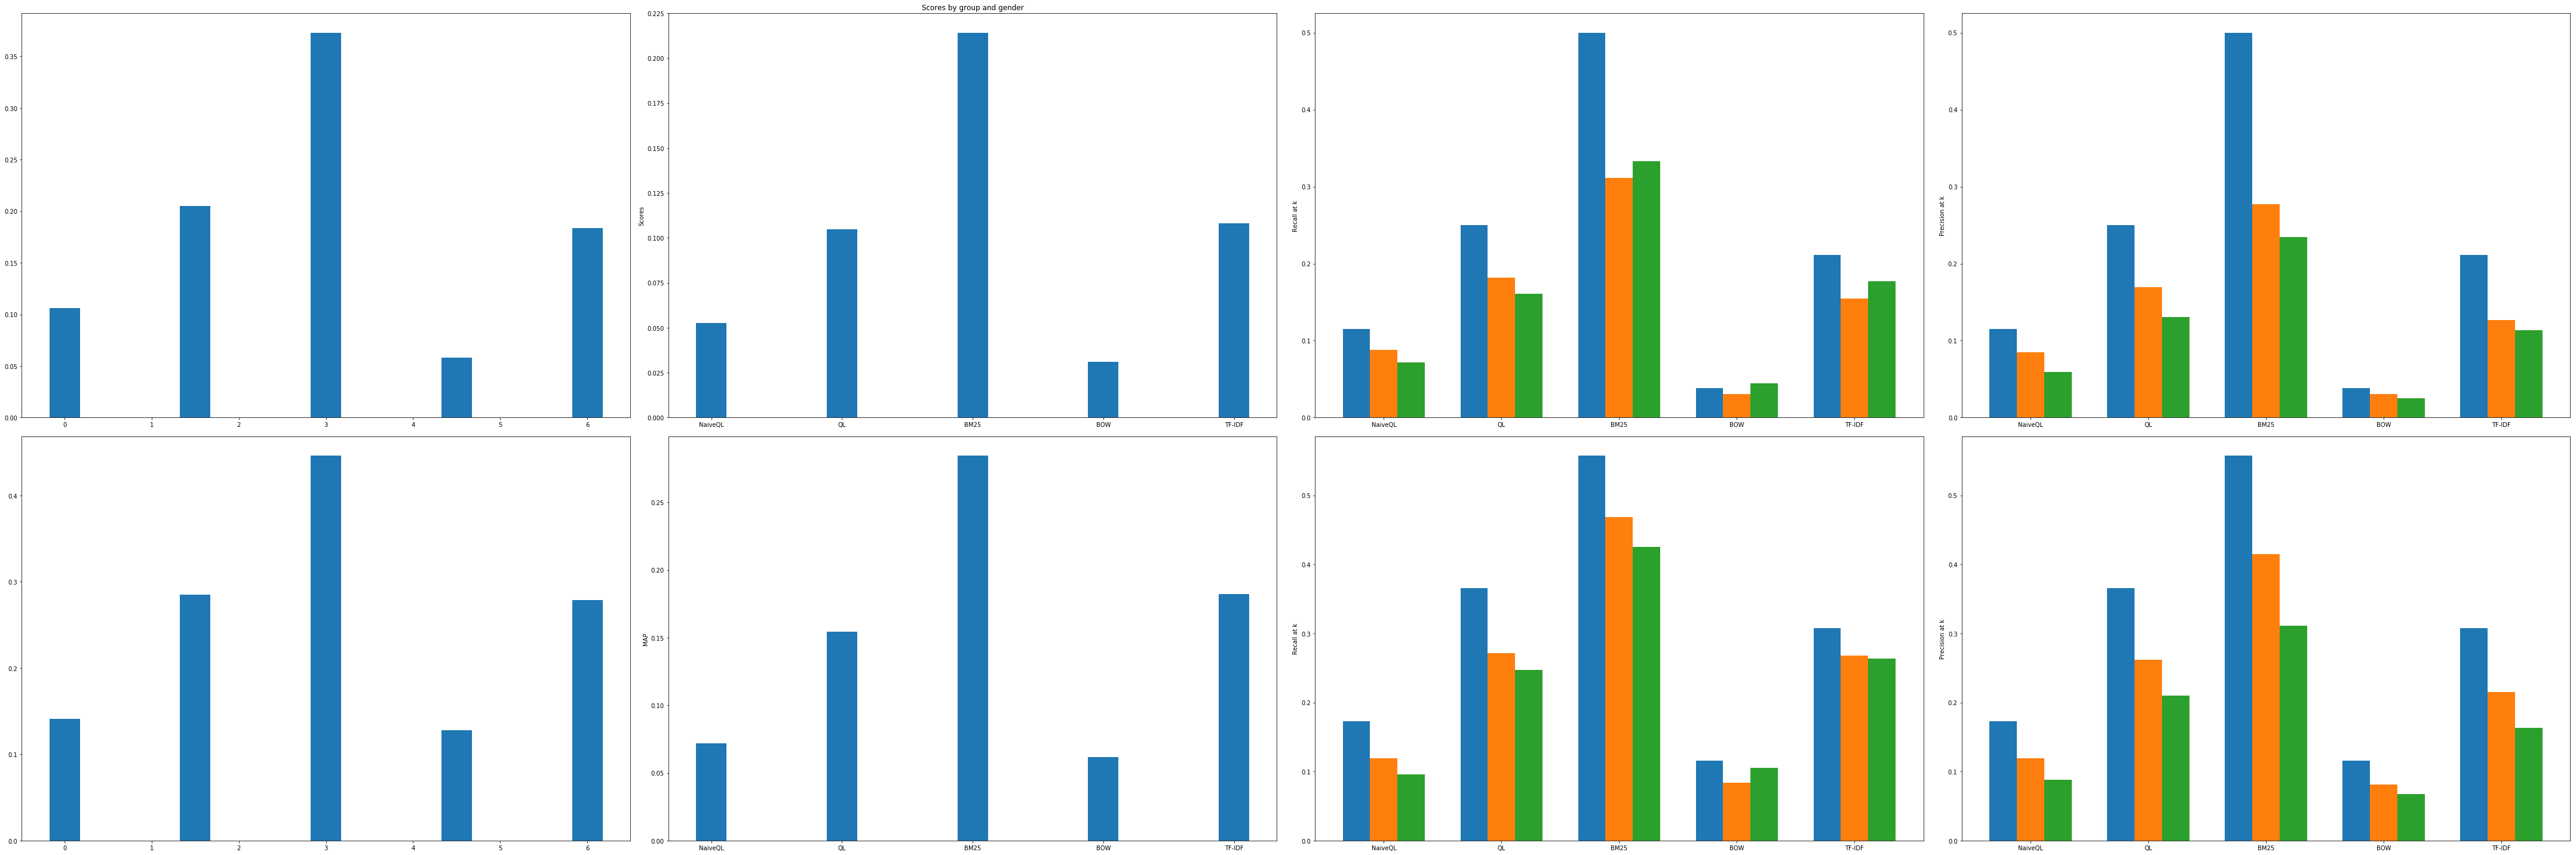

In [67]:
# TODO: Implement this! (20 points)
search_fns = [name for name, _ in list_of_search_fns]
metrics = [name for name, _ in list_of_metrics]
x = np.arange(len(list_of_search_fns))*1.5  # the label locations
width = 0.35  # the width of the bars
one_bar_plots = metrics[0:2]#['ERR', 'MAP']
three_bar_plots =  ['Recall at k', 'Precision at k']
#three_bar_metrics = [['Recall@1', 'Recall@5', 'Recall@10'],
#                     ['Precision@1', 'Precision@5', 'Precision@10']]
three_bar_metrics = [metrics[2:5], metrics[5:]]
shift_bar = [-width, 0, width]

fig, ax = plt.subplots(len(index_sets), len(one_bar_plots)+len(three_bar_plots))
fig.set_figheight(20)
fig.set_figwidth(60)

for row, index_set in enumerate(index_sets):
    row_results = results[index_set]
    for col, metric in enumerate(one_bar_plots):
        values = [row_results[s][metric] for s in search_fns]
        ax[row, col].bar(x, values, width)
    ax[row, col].set_ylabel(metric)
    ax[row, col].set_xticks(x)
    ax[row, col].set_xticklabels(search_fns)
    
    offset = len(one_bar_plots)
    for col, metric in enumerate(three_bar_plots):
        for bar_num, bar_metric in enumerate(three_bar_metrics[col]):
            values = [row_results[s][bar_metric] for s in search_fns]
            ax[row, offset+col].bar(x + shift_bar[bar_num], values, width)
        ax[row, offset+col].set_ylabel(metric)
        ax[row, offset+col].set_xticks(x)
        ax[row, offset+col].set_xticklabels(search_fns)
    #for col, plot in enumerate(metric_plots):
    #    for bar in range(num_bars[col]):
    #        values = [v in row_results]
    #        ax[row, col].bar(x - width/num_bars[col], row_results[], width, label='Men')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0,1].set_ylabel('Scores')
ax[0,1].set_title('Scores by group and gender')
ax[0,1].set_xticks(x)
ax[0,1].set_xticklabels(labels)
ax[0,1].legend()

fig.tight_layout()

plt.show()

Write a summary of what you observe in the results.
You summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.      
*Hint*: You may build upon the answers from the previous sections. 

*TODO: Answer this!*